In [ ]:
# --- Imports ---
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from player_setup import generate_players
from auction import Auction

# Ensure plots render inline
%matplotlib inline


In [ ]:
# --- Simulation Configuration ---

slow_speed = (0.0, 0.5)
slow_mean = 0.7
fast_mean = 0.8  # fixed to isolate speed effect

fast_speed_ranges = [
    (0.3, 0.6),
    (0.3, 0.7),
    (0.3, 0.8),
    (0.3, 0.9)
]

num_slow = 5
num_fast = 5
num_rounds = 1000000
bid_range_width = 0.1


In [ ]:
# --- Run Simulations ---

results = []

for fast_speed in fast_speed_ranges:
    players = generate_players(
        num_players=num_slow + num_fast,
        num_reactive=num_fast,
        gaussian_speed_min_range=slow_speed,
        gaussian_speed_max_range=slow_speed,
        gaussian_bid_prop_mean_range=(slow_mean, slow_mean),
        gaussian_bid_prop_std_range=(bid_range_width, bid_range_width),
        reactive_speed_min_range=fast_speed,
        reactive_speed_max_range=fast_speed,
        reactive_bid_prop_mean_range=(fast_mean, fast_mean),
        reactive_bid_prop_std_range=(bid_range_width, bid_range_width),
        reactive_others_mean_range=(slow_mean, slow_mean),
        reactive_others_std_range=(bid_range_width, bid_range_width)
    )

    auction = Auction(players, cutoff_time_range=(0.9, 1.0))
    round_results, winnings = auction.run_simulation(num_rounds)

    fast_ids = [p.player_id for p in players if "Reactive" in str(type(p))]
    slow_ids = [p.player_id for p in players if p.player_id not in fast_ids]

    fast_profits = [winnings[i] for i in fast_ids]
    slow_profits = [winnings[i] for i in slow_ids]
    fast_wins = sum(1 for r in round_results if r['winner'] and r['winner'][0] in fast_ids)
    slow_wins = sum(1 for r in round_results if r['winner'] and r['winner'][0] in slow_ids)

    total_fast_bids = total_fast_missed = total_slow_bids = total_slow_missed = 0
    for r in round_results:
        strategies = r["strategies"]
        cutoff = r["cutoff_time"]
        for pid in fast_ids:
            if strategies[pid][2] >= cutoff:
                total_fast_missed += 1
            total_fast_bids += 1
        for pid in slow_ids:
            if strategies[pid][2] >= cutoff:
                total_slow_missed += 1
            total_slow_bids += 1

    results.append({
        "fast_speed_range": fast_speed,
        "fast_max_speed": fast_speed[1],
        "slow_total_profit": round(sum(slow_profits), 5),
        "slow_win_rate": round(slow_wins / num_rounds, 5),
        "fast_total_profit": round(sum(fast_profits), 5),
        "fast_win_rate": round(fast_wins / num_rounds, 5),
        "fast_miss_rate": round(total_fast_missed / total_fast_bids, 5),
        "slow_miss_rate": round(total_slow_missed / total_slow_bids, 5)
    })

df = pd.DataFrame(results)
df["fast_speed_range"] = df["fast_speed_range"].astype(str)
df.to_csv("speed_grid__speeds_results.csv", index=False)
df.head()


,fast_speed_range,fast_max_speed,slow_total_profit,slow_win_rate,fast_total_profit,fast_win_rate,fast_miss_rate,slow_miss_rate
0,"(0.3, 0.6)",0.6,105454.80171,0.30729,94194.37007,0.69271,0.0,0.0
1,"(0.3, 0.7)",0.7,93558.68778,0.29897,103943.39908,0.70103,0.0,0.0
2,"(0.3, 0.8)",0.8,93556.23163,0.29859,103615.75810,0.70141,0.0,0.0
3,"(0.3, 0.9)",0.9,114253.17700,0.29938,83108.82715,0.70062,0.0,0.0


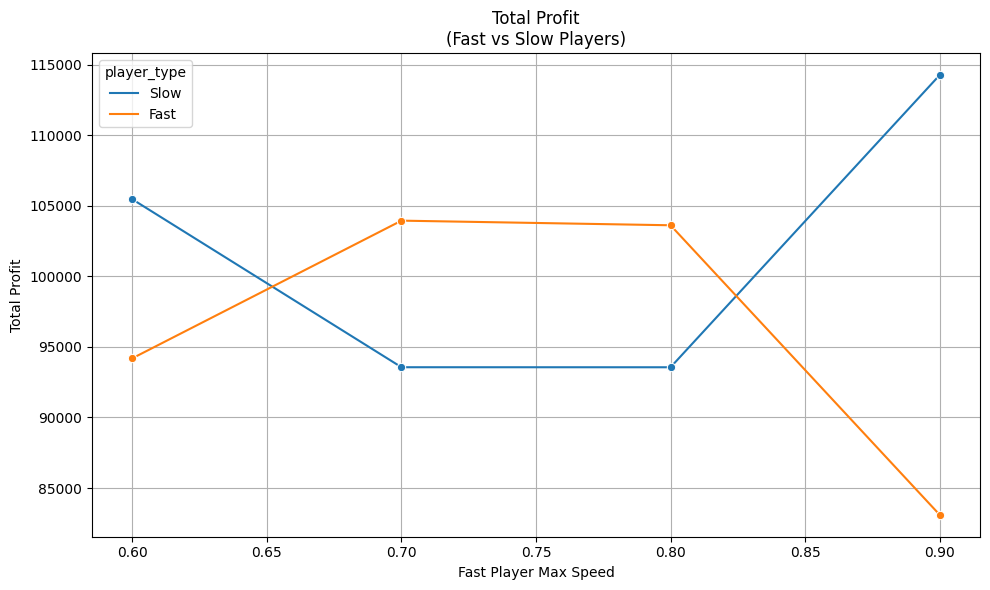

In [ ]:
profit_df = pd.concat([
    df[["fast_max_speed", "slow_total_profit"]].rename(columns={"slow_total_profit": "total_profit"}).assign(player_type="Slow"),
    df[["fast_max_speed", "fast_total_profit"]].rename(columns={"fast_total_profit": "total_profit"}).assign(player_type="Fast")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=profit_df, x="fast_max_speed", y="total_profit", hue="player_type", marker="o")
plt.title("Total Profit\n(Fast vs Slow Players)")
plt.xlabel("Fast Player Max Speed")
plt.ylabel("Total Profit")
plt.grid(True)
plt.tight_layout()
plt.savefig("profit_comparison_by_speed.png")
plt.show()


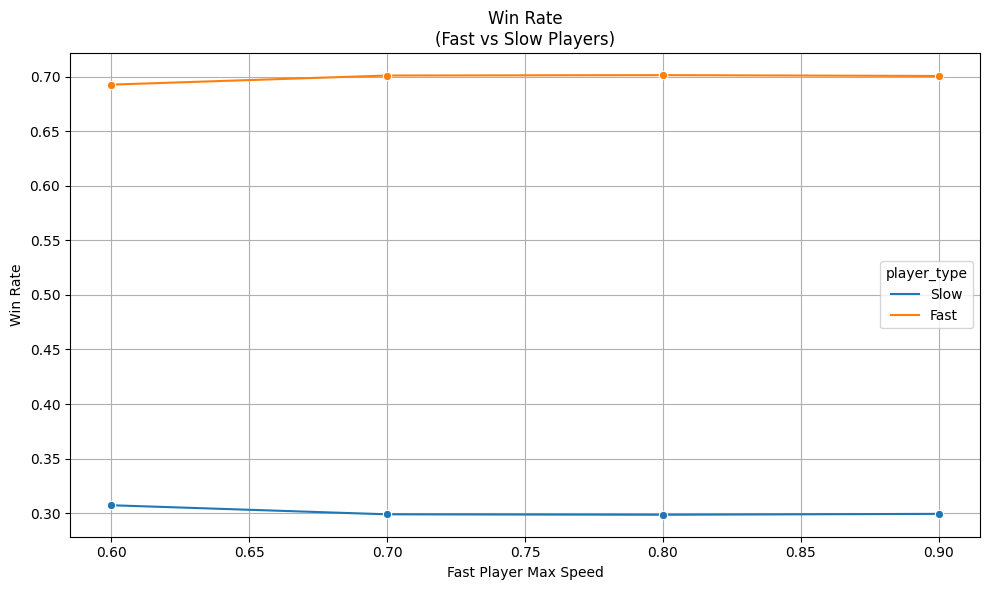

In [ ]:
winrate_df = pd.concat([
    df[["fast_max_speed", "slow_win_rate"]].rename(columns={"slow_win_rate": "win_rate"}).assign(player_type="Slow"),
    df[["fast_max_speed", "fast_win_rate"]].rename(columns={"fast_win_rate": "win_rate"}).assign(player_type="Fast")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=winrate_df, x="fast_max_speed", y="win_rate", hue="player_type", marker="o")
plt.title("Win Rate\n(Fast vs Slow Players)")
plt.xlabel("Fast Player Max Speed")
plt.ylabel("Win Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig("winrate_comparison_by_speed.png")
plt.show()
